# AFW Tables: A Guided Tour
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@ih64)), **Second Owner** ([@username2](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username2))
<br>Last Verified to Run: **20XX-XX-XX**
<br>Verified Stack Release: **16.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Make a bare bones afw schema and table;
2. Set and get values in a schema and table;
3. Read and write a source detection catalog table;
4. Learn to use source detection catalog methods, and to avoid common pitfalls;
5. Learn to use source match vectors;

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd .. && python setup.py -q develop --user && cd -

/home/ishasan/lsst/StackClub/Basics


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-ishasan-r160
lsst_distrib          16.0+1     	current v16_0 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline
#%matplotlib ipympl

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown

In [5]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

import lsst.afw.display as afwDisplay

## Your first table

To begin, we will make a bear bones afw table so we can clearly showcase important concepts. First we will make the simplest table possible by hand. While creating tables by hand will not likely be the standard use case, it is useful in a tutorail standpoint, as it will allow us to excercise concepts one at a time

In [6]:
#afw tables need a schemea to tell the table how its data are organized
#lets have a look at a simple schema
min_schema = afwTable.SourceTable.makeMinimalSchema()

In [7]:
#but what is the schema exactly? priting it out can be informative
print(min_schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



Our schema contains 4 Fields: one for each celestial coordinate, an id that uniquely defines it, and a 'parent', which lists the id of the source this source was deblended from. We will deal with the parent column in more detail in a few cells, but for now you can ignore it.

Each field has some accomanying information to go along with it. In addition to its name, we get a helpful docstring describing it. We also get the units that values for this field must have. For example, any value associated with the id key has to be a long, and all entries for celestial coordniates have to be instances of an Angle class. We will showcase the Angle class shortly.

If printing out the schema gives you more information that you want, you can get the names. If the names are informative enough, this might be all you need.

In [8]:
min_schema.getNames()

{'coord_dec', 'coord_ra', 'id', 'parent'}

In [9]:
#we can also add another field to the schema, using a call pattern like this
min_schema.addField("r_mag", type=np.float32, doc="r band flux", units="mag")
#lets make sure the field was added by printing out the schema once more
print(min_schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="r_mag", doc="r band flux", units="mag"), Key<F>(offset=32, nElements=1)),
)



We pause here to point ou some caviets. 
1. schemas are append only. You can add new fields, but you cannot remove them. 
2. the units you use have to be understood by astropy. You can find a list of acceptable units at the bottom of this page http://docs.astropy.org/en/stable/units/index.html#module-astropy.units
3. specific types are allowed. The short and long of it is you may use floats, ints, longs, strings, Angle objects, and arrays. For more details you can go to the bottom of this page http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/afw_table.html

In [10]:
#now that we have a schema, we can use it to make a table
min_table = afwTable.BaseCatalog(min_schema)
#our table is empty, and we can check this by looking at its length
print('our minimal table has {} rows'.format(len(min_table)))

our minimal table has 0 rows


Now we will add some data to our minimal catalog. Catalogs are collections of 'records', which actually contain the table's data. To add some data to our catalog, we will have to create some records to add on. Records must adhere to the schema that the table has, and so we must add data in field by field.

In [11]:
#make a new record.
rec = min_table.addNew()

In [12]:
#grab a hold of the keys for the record. We will use these to add data 
keys = min_schema.extract('*') #this returns a dictionary of all the fields

#access the dictionary one field at a time, and grab each field's key
id_key = keys['id'].key
ra_key = keys['coord_ra'].key
dec_key = keys['coord_dec'].key
parent_key = keys['parent'].key
r_mag_key = keys['r_mag'].key

#use the keys to add data in our record
rec.set(id_key, 1)
rec.set(r_mag_key, 19.0)
rec.set(ra_key, afwGeom.Angle(33.89))
rec.set(dec_key, afwGeom.Angle(42.1))
rec.set(parent_key, 0)

Notice to set the ra and dec, we needed to create afwGeom.Angle objects. These are in units of radians by default. Additionally, we set the parent to zero. This means this record refers to the object before any deblending occoured. Lets look at our table now to see how it stands

In [13]:
min_table

<class 'lsst.afw.table.base.base.BaseCatalog'>
 id coord_ra coord_dec parent r_mag
      rad       rad            mag 
--- -------- --------- ------ -----
  1    33.89      42.1      0  19.0

We will flesh out the parent column a bit more by adding our next record. Notice we can keep using the keys we defined above. Notice our second record's parent is listed as 1. This means the object 2 was the result of being deblended from object 1, i.e. object 2 is a child object of object 1.

In [14]:
rec = min_table.addNew()
rec.set(id_key, 2)
rec.set(r_mag_key, 18.5)
rec.set(ra_key, afwGeom.Angle(32.01))
rec.set(dec_key, afwGeom.Angle(42.5))
rec.set(parent_key, 1)
min_table

<class 'lsst.afw.table.base.base.BaseCatalog'>
 id coord_ra coord_dec parent r_mag
      rad       rad            mag 
--- -------- --------- ------ -----
  1    33.89      42.1      0  19.0
  2    32.01      42.5      1  18.5

In [15]:
#your turn. add one more record to our table



In [16]:
#now that we have multiple records in our table, we can iterate over them, or select particular ones
min_table[1]

<class 'lsst.afw.table.base.base.BaseRecord'>
id: 2
coord_ra: 32.01 rad
coord_dec: 42.5 rad
parent: 1
r_mag: 18.5

In [17]:
#you can grab values from particular records by using our keys
min_table[1].get(id_key)

2

## Using source catalogs produced by DM

A more typical use case will be to read in a catalog that is produced by a DM process. We will show how to read in and work with a source catalog from HSC data in the following section. 

### data access
If you know the path to your source catalog, there is a quick way to read it in. However, it is often more powerful to the 'data butler' to fetch data for you. The butler knows about camera geometry, sensor characteristics, where data are located, and so forth. Having this anciliary information on hand is often very useful. For completeness we will demostrate both ways of reading in a source catalog, with the note that it is largely considered better pratice to use the data butler. 

The data butler deserves a tutorial in its own right, and so we will defer further details on it until later. For now, you may think of it as an abstraction that allows you to quickly fetch data. The user just needs to point the butler to where to look and what to look for.

In [18]:
#here's the quick and dirty way
file_path = '/project/shared/data/Twinkles_subset/output_data_v2/src/v235-fr/R22/S11.fits'
source_cat = afwTable.SourceCatalog.readFits(file_path)

In [19]:
#here is the way to get the catalog with a butler
#first set up our butler by telling it to look at this twinkles directory
butler = dafPersist.Butler('/project/shared/data/Twinkles_subset/output_data_v2')
#now we put together a dataId that uniquely specifies a datum
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}

/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_mosaic/16.0+1/python/lsst/meas/mosaic/utils.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/traitlets/config/application.py

In [20]:
#use the dataId and the 'src' to get the source catalog. 
source_cat = butler.get('src', **dataId)

A few comments are in order on questions you may be having about the butler, and the previous cell. First, there is no good way to know what dataId's exist and correspond to data. That means you have to know ahead of time what dataId's make sense to use. DM is working hard on fixing this. Second, 'src' refers to a very specific data product in the DM philosophy. This is a measurment catalog contains the results of different measurement algorithms on detected sources on an individual CCD. We will meet some other catalogs later in the tutorial. For now, lets get to know this src

In [21]:
#check its schema. Heads up, the schema is pretty big!
source_cat.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psfCandidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psfUsed", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Field[

These schemas tend to be pretty large, because every measurement algorithm will create several fields. There are handy ways of grabbing fields that are interesting to you. Suppose you are interested in shape measurements. We can use unix like pattern matching with the extract method to search the schema. This returns a dictionary where the keys are the schema fields whose names match the pattern you specified, and the values are the fields themselves. If we are just intested in the field names, we can do this

In [22]:
source_cat.getSchema().extract('*HSM*Psf*').keys()

dict_keys(['ext_shapeHSM_HsmPsfMoments_flag_badCentroid', 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge', 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative', 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative', 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum', 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_resetToPeak', 'ext_shapeHSM_HsmPsfMoments_x', 'ext_shapeHSM_HsmPsfMoments_y', 'ext_shapeHSM_HsmPsfMoments_xx', 'ext_shapeHSM_HsmPsfMoments_yy', 'ext_shapeHSM_HsmPsfMoments_xy', 'ext_shapeHSM_HsmPsfMoments_flag', 'ext_shapeHSM_HsmPsfMoments_flag_no_pixels', 'ext_shapeHSM_HsmPsfMoments_flag_not_contained', 'ext_shapeHSM_HsmPsfMoments_flag_parent_source'])

Looking at the very bottom of the schema we printed out above, you will notice some of the fields are named 'slot_'. These are called aliases in the schema, and can help you deal with any ambiguity in the table. For example, there are several algorithms used to measure the centroid, and many fileds with 'centroid' in their name as a result. If you want to have quick access to one algorithms measurement result, you can set up a slot alias for it. Lets do a working example on the first record in our table

In [23]:
slot_centroid = source_cat[0].getCentroid()
gauss_cent_x, gauss_cent_y = (source_cat['base_GaussianCentroid_x'][0], source_cat['base_GaussianCentroid_y'][0])
sdss_cent_x, sdss_cent_y = (source_cat['base_SdssCentroid_x'][0], source_cat['base_SdssCentroid_y'][0])

print('gaussian centroid is {}, {}'.format(gauss_cent_x, gauss_cent_y))
print('sloan centroid is {}, {}'.format(sdss_cent_x, sdss_cent_y))
print('slot centroid is {}'.format(slot_centroid))


gaussian centroid is 1980.019868931552, 7.642499448278578
sloan centroid is 1980.0, 8.0
slot centroid is (1980, 8)


In [24]:
#aliasing works with other methods
psf_flux_key = source_cat.getPsfFluxKey()
id_key = source_cat.getIdKey()

As advertised, the slot centroid and SDSS centroid are the same. We also used some syntactic sugar to access the gaussian centroids and sdss centroids, which will be familiar to you if you are an astropy tables user. Speaking of which, you can make an astropy table version of a source catalog. However, source catalogs support a lot of fast operations for common use cases which we will disucss. 

In [25]:
source_cat.asAstropy()

id,coord_ra,coord_dec,parent,calib_detected,calib_psfCandidate,calib_psfUsed,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,base_GaussianCentroid_x,base_GaussianCentroid_y,base_GaussianCentroid_flag,base_GaussianCentroid_flag_noPeak,base_GaussianCentroid_flag_resetToPeak,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xSigma,slot_Centroid_xSigma,base_SdssCentroid_ySigma,slot_Centroid_ySigma,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianCentroid_flag_badInitialCentroid,base_GaussianFlux_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianCentroid_flag_badInitialCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianCentroid_flag_badInitialCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianCentroid_flag_badInitialCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAt

In [26]:
#sorting is supported. by default catalogs are sorted by id
source_cat.isSorted(id_key)

True

In [27]:
#you can cut on the catalog
#make a bool array to only keep sources with positive psf flux
#we will showcase another way to use aliasing too
psf_mask = source_cat.getPsfFlux() > 0
pos_flux = source_cat.subset(psf_mask)

#you can sort on other keys too
flux_key = pos_flux.getPsfFluxKey()
pos_flux.sort(flux_key)
pos_flux.isSorted(flux_key)

True

In [28]:
#get the children of particular objects
#this is useful if you want to understand how one object was deblended
source_cat.getChildren(1010357503918) #the argument is the id of the parent object

#note that this will only work if the source catalog is sorted on id or parent

<class 'lsst.afw.table.source.source.SourceCatalog'>
      id           coord_ra      ... calib_photometry_reserved
                     rad         ...                          
------------- ------------------ ... -------------------------
1010357504605 0.9276100366033875 ...                     False
1010357504606 0.9276113859032618 ...                     False

Some operations (like writing to disk) are only allowed if the source catalog is contiguous in memory. You can check if this is the case

In [29]:
source_cat.isContiguous()

True

In [30]:
pos_flux.isContiguous()

False

You can force the table to be contiguous if you make a deep copy of it

In [31]:
pos_flux = pos_flux.copy(deep=True)
pos_flux.isContiguous()

True

In [32]:
#use the between method to get the indicies of values within a range
pos_flux.between(1e4,1e6,psf_flux_key)

slice(2052, 2624, 1)

In [33]:
#the slice object tells you the (start, stop, stride) for values that fit our querry
#you can check to see that the first record outside the slice is above the flux threshold
pos_flux[2624].getPsfFlux()

1095968.2558799293

In [34]:
#and that the last element in the slice is inside the threshold
pos_flux[2623].getPsfFlux()

910716.5910917423

In [35]:
#your turn. confirm the lower limits of the between query
#pos_flux[...].getPsfFlux


In [36]:
#the upper and lower bound methods work similarly
pos_flux.upper_bound(1e4, psf_flux_key)

2052

In [37]:
pos_flux.lower_bound(1e6, psf_flux_key)

2624

Now that we have introduced the new bells and whistles that the source catalog has in its schema and methods, we will do a toy example of star-galaxy separation. This small demo is ment to introduce using flags and particular columns along with some of the methods we introduced above, to make a plot

In [57]:
#let's select sources that were not deblended
select_mask = source_cat['deblend_nChild'] == 0
select_mask &= source_cat['parent'] == 0

# use the extendedness column for a mock star/galaxy seperation
# we only want to use columns where this algorithm worked
#the flag is set true if there was a failure, so we invert the flag values here
select_mask &= ~source_cat['base_ClassificationExtendedness_flag']

# we will also use the sloan shapes to measure size
select_mask &= ~source_cat['base_SdssShape_flag']

# and a simple aperture flux for the brightness
select_mask &= ~source_cat['base_CircularApertureFlux_12_0_flag']

size_bright_cat = source_cat.subset(select_mask)

In [64]:
plt.style.use('seaborn-poster')

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


Text(0,0.5,'size')

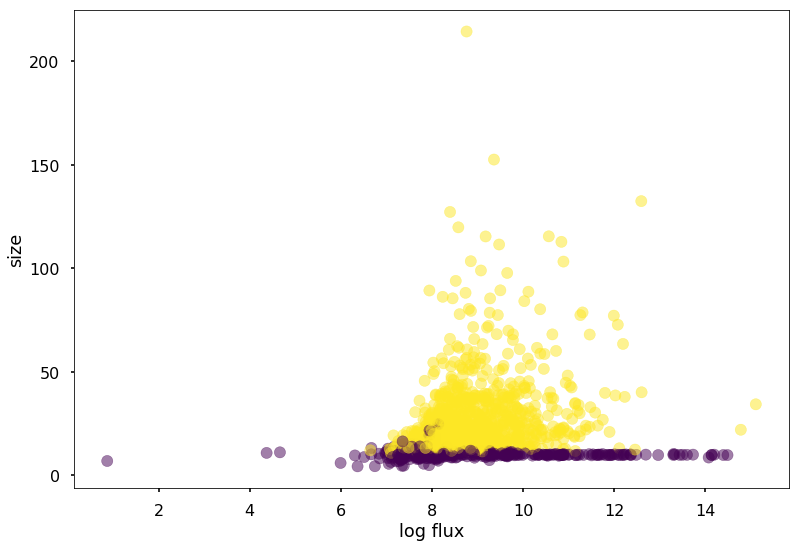

In [67]:
plt.scatter(np.log(size_bright_cat['base_CircularApertureFlux_12_0_flux']), 
           size_bright_cat['base_SdssShape_xx'] + size_bright_cat['base_SdssShape_yy'],
           c=size_bright_cat['base_ClassificationExtendedness_value'], alpha=.5)
plt.xlabel('log flux')
plt.ylabel('size')

In [59]:
source_cat.schema.extract('*CircularApertureFlux_12*')

{'base_CircularApertureFlux_12_0_flux': SchemaItem(key=Key<D>(offset=616, nElements=1), field=Field['D'](name="base_CircularApertureFlux_12_0_flux", doc="flux within 12.000000-pixel aperture", units="count")),
 'base_CircularApertureFlux_12_0_fluxSigma': SchemaItem(key=Key<D>(offset=624, nElements=1), field=Field['D'](name="base_CircularApertureFlux_12_0_fluxSigma", doc="1-sigma flux uncertainty", units="count")),
 'base_CircularApertureFlux_12_0_flag': SchemaItem(key=Key['Flag'](offset=32, bit=63), field=Field['Flag'](name="base_CircularApertureFlux_12_0_flag", doc="General Failure Flag")),
 'base_CircularApertureFlux_12_0_flag_apertureTruncated': SchemaItem(key=Key['Flag'](offset=632, bit=0), field=Field['Flag'](name="base_CircularApertureFlux_12_0_flag_apertureTruncated", doc="aperture did not fit within measurement image")),
 'base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated': SchemaItem(key=Key['Flag'](offset=632, bit=1), field=Field['Flag'](name="base_CircularApertureFlux_

## Summary

Remind the user what they have done, and what they should now be able to do.

You could also point them to a related tutorial or reference source, to help them go further.